# **GRU From Scratch in Python**
*By Cristian Leo*

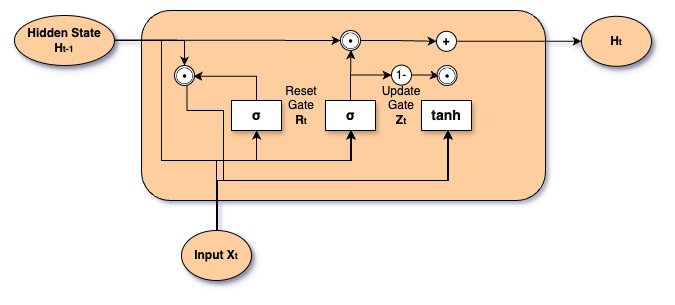

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Custom classes (built from scratch)
from src.model import WeightInitializer
from src.trainer import PlotManager, EarlyStopping

In [2]:
class GRU:
    """
    Gated Recurrent Unit (GRU) network.
    
    Parameters:
    - input_size: int, dimensionality of input space
    - hidden_size: int, number of GRU units
    - output_size: int, dimensionality of output space
    - init_method: str, weight initialization method (default: 'xavier')
    """
    def __init__(self, input_size, hidden_size, output_size, init_method='xavier'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_initializer = WeightInitializer(method=init_method)

        # Initialize weights
        self.wz = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wr = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))
        self.wh = self.weight_initializer.initialize((hidden_size, hidden_size + input_size))

        # Initialize biases
        self.bz = np.zeros((hidden_size, 1))
        self.br = np.zeros((hidden_size, 1))
        self.bh = np.zeros((hidden_size, 1))

        # Initialize output layer weights and biases
        self.why = self.weight_initializer.initialize((output_size, hidden_size))
        self.by = np.zeros((output_size, 1))

    @staticmethod
    def sigmoid(z):
        """
        Sigmoid activation function.
        
        Parameters:
        - z: np.ndarray, input to the activation function
        
        Returns:
        - np.ndarray, output of the activation function
        """
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dsigmoid(y):
        """
        Derivative of the sigmoid activation function.

        Parameters:
        - y: np.ndarray, output of the sigmoid activation function

        Returns:
        - np.ndarray, derivative of the sigmoid function
        """
        return y * (1 - y)

    @staticmethod
    def dtanh(y):
        """
        Derivative of the hyperbolic tangent activation function.

        Parameters:
        - y: np.ndarray, output of the hyperbolic tangent activation function

        Returns:
        - np.ndarray, derivative of the hyperbolic tangent function
        """
        return 1 - y * y

    def forward(self, x):
        """
        Forward pass through the GRU network.

        Parameters:
        - x: np.ndarray, input to the network

        Returns:
        - np.ndarray, output of the network
        - list, caches containing intermediate values for backpropagation
        """
        caches = []
        h_prev = np.zeros((self.hidden_size, 1))
        h = h_prev

        # Loop through the input sequence
        for t in range(x.shape[0]):
            x_t = x[t].reshape(-1, 1)
            combined = np.vstack((h_prev, x_t))
            
            # Update gate
            z = self.sigmoid(np.dot(self.wz, combined) + self.bz)

            # Reset gate
            r = self.sigmoid(np.dot(self.wr, combined) + self.br)

            # Hidden state
            combined_r = np.vstack((r * h_prev, x_t))
            h_ = np.tanh(np.dot(self.wh, combined_r) + self.bh)
            
            # Update hidden state
            h = (1 - z) * h_prev + z * h_

            # Cache intermediate values for backpropagation
            cache = (h_prev, z, r, h_, x_t, combined, combined_r, h)
            caches.append(cache)

            h_prev = h

        # Output layer
        y = np.dot(self.why, h) + self.by
        return y, caches

    def backward(self, dy, caches, clip_value=1.0):
        """
        Backward pass through the GRU network.

        Parameters:
        - dy: np.ndarray, gradient of the loss with respect to the output
        - caches: list, caches from the forward pass
        - clip_value: float, value to clip gradients to (default: 1.0)

        Returns:
        - tuple, gradients of the loss with respect to the parameters
        """
        # Initialize gradients
        dWz, dWr, dWh = [np.zeros_like(w) for w in (self.wz, self.wr, self.wh)]
        dbz, dbr, dbh = [np.zeros_like(b) for b in (self.bz, self.br, self.bh)]
        dWhy = np.zeros_like(self.why)
        dby = np.zeros_like(self.by)

        # Ensure dy is reshaped to match output size
        dy = dy.reshape(self.output_size, -1)
        dh_next = np.zeros((self.hidden_size, 1))  # shape must match hidden_size

        # Backpropagate through time
        for cache in reversed(caches):
            h_prev, z, r, h_, x_t, combined, combined_r, h = cache

            # Add gradient from next step to current output gradient
            dh = np.dot(self.why.T, dy) + dh_next
            dh_ = dh * z * self.dtanh(h_)
            dz = dh * (h_ - h_prev) * self.dsigmoid(z)
            dr = np.dot(self.wh[:, :self.hidden_size].T, dh_) * h_prev * self.dsigmoid(r)

            # Update gradients with respect to weights and biases
            dWz += np.dot(dz, combined.T)
            dWr += np.dot(dr, combined.T)
            dWh += np.dot(dh_, combined_r.T)

            dbz += dz.sum(axis=1, keepdims=True)
            dbr += dr.sum(axis=1, keepdims=True)
            dbh += dh_.sum(axis=1, keepdims=True)

            # Compute the gradient for the previous time step
            dh_prev = dh * (1 - z) + np.dot(self.wz[:, :self.hidden_size].T, dz) + np.dot(self.wr[:, :self.hidden_size].T, dr)

            dh_next = dh_prev

        # Update output layer weights and biases
        dWhy += np.dot(dy, h.T)
        dby += dy

        gradients = (dWz, dWr, dWh, dbz, dbr, dbh, dWhy, dby)

        # Gradient clipping
        for i in range(len(gradients)):
            np.clip(gradients[i], -clip_value, clip_value, out=gradients[i])

        return gradients

    def update_params(self, grads, learning_rate):
        """
        Update the parameters of the network using the gradients.

        Parameters:
        - grads: tuple, gradients of the loss with respect to the parameters
        - learning_rate: float, learning rate
        """
        dWz, dWr, dWh, dbz, dbr, dbh, dWhy, dby = grads

        self.wz -= learning_rate * dWz
        self.wr -= learning_rate * dWr
        self.wh -= learning_rate * dWh

        self.bz -= learning_rate * dbz
        self.br -= learning_rate * dbr
        self.bh -= learning_rate * dbh

        self.why -= learning_rate * dWhy
        self.by -= learning_rate * dby


class GRUTrainer:
    """
    Trainer for the GRU network.

    Parameters:
    - model: GRU, the GRU network to train
    - learning_rate: float, learning rate for the optimizer
    - patience: int, number of epochs to wait before early stopping
    - verbose: bool, whether to print training information
    - delta: float, minimum change in validation loss to qualify as an improvement
    """
    def __init__(self, model, learning_rate=0.01, patience=7, verbose=True, delta=0):
        self.model = model
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        self.early_stopping = EarlyStopping(patience, verbose, delta)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=1, clip_value=1.0):
        """
        Train the GRU network.

        Parameters:
        - X_train: np.ndarray, training data
        - y_train: np.ndarray, training labels
        - X_val: np.ndarray, validation data
        - y_val: np.ndarray, validation labels
        - epochs: int, number of training epochs
        - batch_size: int, size of mini-batches
        - clip_value: float, value to clip gradients to
        """
        # Loop through epochs
        for epoch in range(epochs):
            epoch_losses = []

            # Loop through mini-batches
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                losses = []
                
                # Loop through samples in the mini-batch
                for x, y_true in zip(batch_X, batch_y):
                    y_pred, caches = self.model.forward(x)

                    # Compute loss
                    loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
                    losses.append(loss)
                    
                    # Backpropagation to get gradients
                    dy = y_pred - y_true.reshape(-1, 1)
                    grads = self.model.backward(dy, caches, clip_value=clip_value)
                    self.model.update_params(grads, self.learning_rate)

                batch_loss = np.mean(losses)
                epoch_losses.append(batch_loss)

            avg_epoch_loss = np.mean(epoch_losses)
            self.train_losses.append(avg_epoch_loss)

            # Validate the model
            if X_val is not None and y_val is not None:
                val_loss = self.validate(X_val, y_val)
                self.val_losses.append(val_loss)

                if epoch % 10 == 0:
                    print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.5f}, Val Loss: {val_loss:.5f}')
                
                # Check early stopping condition
                self.early_stopping(val_loss)
                if self.early_stopping.early_stop:
                    print("Early stopping")
                    break
            else:
                print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.5f}')


    def compute_loss(self, y_pred, y_true):
        """
        Compute mean squared error loss.
        """
        return np.mean((y_pred - y_true) ** 2)

    def validate(self, X_val, y_val):
        """
        Validate the model on a separate set of data.
        """
        val_losses = []
        for x, y_true in zip(X_val, y_val):
            y_pred, _ = self.model.forward(x)
            loss = self.compute_loss(y_pred, y_true.reshape(-1, 1))
            val_losses.append(loss)
        return np.mean(val_losses)


In [3]:
class TimeSeriesDataset:
    """
    Dataset class for time series data.

    Parameters:
    - start_date: str, start date for data retrieval
    - end_date: str, end date for data retrieval
    - look_back: int, number of previous time steps to include in each sample
    - train_size: float, proportion of data to use for training
    """
    def __init__(self, look_back=1, train_size=0.67):
        self.look_back = look_back
        self.train_size = train_size

    def load_data(self):
        """
        Load flight data.
        
        Returns:
        - np.ndarray, training data
        - np.ndarray, testing data
        """
        df = sns.load_dataset('flights')
        # Concatenate year and month columns to create a date column
        df['Date']  = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')
        df = df.set_index('Date')
        df = df.drop(['year', 'month'], axis=1)
        df = df.values.astype(float)  # Use passenger count
        df = self.MinMaxScaler(df)  # Min-max scaling
        train_size = int(len(df) * self.train_size)
        train, test = df[0:train_size,:], df[train_size:len(df),:]
        return train, test
    
    def MinMaxScaler(self, data):
        """
        Min-max scaling of the data.
        
        Parameters:
        - data: np.ndarray, input data
        """
        numerator = data - np.min(data, 0)
        denominator = np.max(data, 0) - np.min(data, 0)
        return numerator / (denominator + 1e-7)

    def create_dataset(self, dataset):
        """
        Create the dataset for time series prediction.

        Parameters:
        - dataset: np.ndarray, input data

        Returns:
        - np.ndarray, input data
        - np.ndarray, output data
        """
        dataX, dataY = [], []
        for i in range(len(dataset)-self.look_back):
            a = dataset[i:(i + self.look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + self.look_back, 0])
        return np.array(dataX), np.array(dataY)

    def get_train_test(self):
        """
        Get the training and testing data.

        Returns:
        - np.ndarray, training input
        - np.ndarray, training output
        - np.ndarray, testing input
        - np.ndarray, testing output
        """
        train, test = self.load_data()
        trainX, trainY = self.create_dataset(train)
        testX, testY = self.create_dataset(test)
        return trainX, trainY, testX, testY

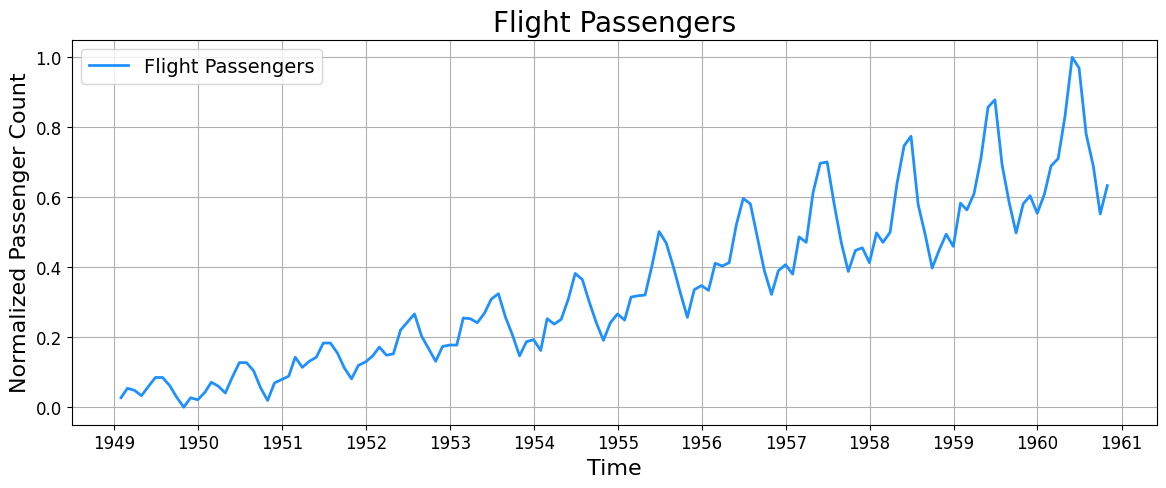

In [4]:
# Instantiate the dataset
dataset = TimeSeriesDataset(train_size=0.7, look_back=1)
trainX, trainY, testX, testY = dataset.get_train_test()

# Create date range
dates = pd.date_range(start='1949-01', end='1961-01', freq='M')

# Combine train and test data
combined = np.concatenate((trainY, testY))

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(dates[:len(combined)], combined, label='Flight Passengers', linewidth=2, color='dodgerblue')
plt.title('Flight Passengers', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Normalized Passenger Count', fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Format x-axis to show years
years = mdates.YearLocator()   # every year
years_fmt = mdates.DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

plt.show()

In [5]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

look_back = 1  # Number of previous time steps to include in each sample
hidden_size = 256  # Number of GRU units
output_size = 1  # Dimensionality of the output space

gru = GRU(input_size=1, hidden_size=hidden_size, output_size=output_size)

# Create and train the GRU using GRUTrainer
trainer = GRUTrainer(gru, learning_rate=1e-3, patience=50, verbose=True, delta=0.001)
trainer.train(trainX, trainY, testX, testY, epochs=1000, batch_size=32)

Epoch 1/1000 - Loss: 0.00810, Val Loss: 0.07847
Epoch 11/1000 - Loss: 0.00514, Val Loss: 0.02297
Epoch 21/1000 - Loss: 0.00306, Val Loss: 0.01192
Epoch 31/1000 - Loss: 0.00266, Val Loss: 0.00962
Epoch 41/1000 - Loss: 0.00258, Val Loss: 0.00910
Epoch 51/1000 - Loss: 0.00256, Val Loss: 0.00897
Epoch 61/1000 - Loss: 0.00256, Val Loss: 0.00893
Epoch 71/1000 - Loss: 0.00256, Val Loss: 0.00892
Epoch 81/1000 - Loss: 0.00256, Val Loss: 0.00891
Epoch 91/1000 - Loss: 0.00256, Val Loss: 0.00891
Early stopping


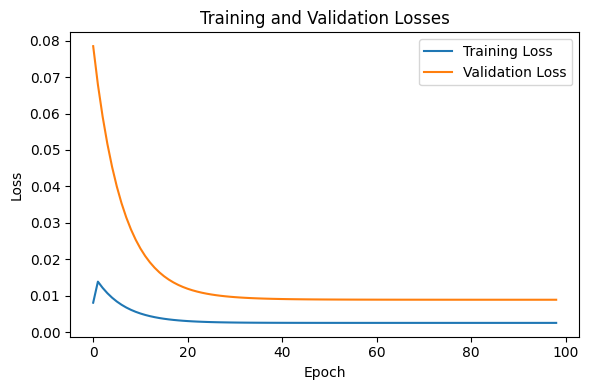

In [6]:
plot_manager = PlotManager()

# Inside your training loop
plot_manager.plot_losses(trainer.train_losses, trainer.val_losses)

# After your training loop
plot_manager.show_plots()